# Clustering using betweenness-based graph algorithms

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import warnings
import itertools
%run data_cleaning.ipynb

In [3]:
# julia import data
centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")
race_data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\weighted_dual_list",delimiter='%',nodetype=str)
nx.draw(stl, with_labels=True, node_size=150, node_color='lightgreen', font_size=10)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dodie\\Downloads\\spring 2024\\trio-capstone\\data\\CensusTractCentroids.csv'

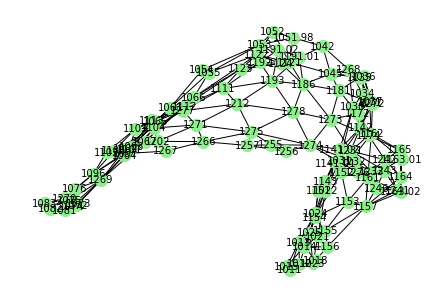

In [4]:
# kayleigh import data

centroid_locations = pd.read_csv(r"data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"data\B08119_stl_city.csv")
race_data = pd.read_csv(r"data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"data\weighted_dual_list",delimiter='%')
nx.draw(stl, with_labels=True, node_size=150, node_color='lightgreen', font_size=10)

In [5]:
by_tract = clean(census_data, race_data)
centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "LAT", "INTPTLON" : "LON"})
full_data = by_tract.merge(centroid_locations_small, on='location')
full_data.head()

,location,estimate,transit weight,transit weight (pop),income weight,income weight (pop),race weight,race weight (pop),node id,LAT,LON
0,Census Tract 1011,1039,0.003275,0.434255,0.009653,1.280070,0.007499,0.994323,1011,38.554718,-90.273620
1,Census Tract 1012,1921,0.001162,0.091845,0.009570,0.756349,0.012480,0.986410,1012,38.561824,-90.274863
2,Census Tract 1013,2161,0.003697,0.259777,0.009560,0.671698,0.013909,0.977253,1013,38.566560,-90.264211
3,Census Tract 1014,1502,0.010036,1.014476,0.009614,0.971790,0.010099,1.020846,1014,38.562243,-90.253522
4,Census Tract 1015,1318,0.003381,0.389424,0.009645,1.111024,0.008554,0.985409,1015,38.548544,-90.264511


In [6]:
def mod_max_weighted(graph, k):
    tolerance = 1e-5
    orig = graph.copy()
    to_return = graph.copy()
    q = 0
    q_new = 0
    partition = [orig]
    new_partition = []

    while (len(partition) < k):
        for G in partition:
            # compute modularity matrix B
            G_nodes = list(G.nodes())
            s = np.zeros(len(G_nodes))
            A = nx.to_numpy_array(G, weight='weights')
            degs = list(dict(G.degree()).values())
            B = np.zeros(np.shape(A))
            n = len(G_nodes)
            m = len(G.edges())
            for i in range(n):
                for j in range(n):
                    B[i][j] = A[i][j] - degs[i]*degs[j]/(2*m)
            # find leading eigenvector u of B
            val, vec = np.linalg.eig(B)
            idx = np.argsort(val)[-1]
            largest_vec = vec[:,idx]
            
            # divide nodes into two groups by sign of leading eigenvector
            for i in range(len(largest_vec)):
                if largest_vec[i].real < np.mean(largest_vec):
                    s[i] = -1
                else:
                    s[i] = 1
            
            # create new subgraphs
            n1 = [G_nodes[i] for i in range(n) if s[i] == 1]
            n2 = [G_nodes[i] for i in range(n) if s[i] == -1]
            if len(n1) >= 1:
                new_partition.append(G.subgraph(n1))
            if len(n2) >= 1:
                new_partition.append(G.subgraph(n2))
            
            # update q_new
            q_new = q_new + B.sum()
        
        
        # either stop or re-partition graph
        q_new = q_new / (2*m)
        if abs(q_new - q) > tolerance and q_new < q:
            return partition
        
        else:
            q = q_new
            q_new = 0 
            partition = new_partition
            new_partition = []

    if len(partition) > k: # (this happens if k is odd)
        num_to_combine = len(partition) - k # we need to re-combine this many graphs to get back to k subgraphs
        pairs = [(partition[i], partition[i + 1]) for i in range(0, len(partition), 2)]
        to_test = list(itertools.combinations(pairs, num_to_combine))
        
        # test modularity of all possible combinations to make partition have length k
        best_modularity = 0
        test_idx = 0
        best_test_idx = 0
        for test in to_test:
            partition_copy = partition.copy()
            # remove the pair from the partition and add back in the original before it split into that pair
            for pair in test:
                partition_copy.remove(pair[0])
                partition_copy.remove(pair[1])
                nodes_to_find = list(set(pair[0].nodes()).union(pair[1].nodes()))
                back_together = orig.subgraph(nodes_to_find)
                partition_copy.append(back_together)
            # re-compute modularity and compare to best modularity
            communities = []
            for clust in partition_copy:
                nodes_in_clust = {n for n in clust.nodes()}
                communities.append(nodes_in_clust)
            modularity = nx.community.modularity(orig, communities)
            if modularity > best_modularity:
                best_modularity = modularity
                best_test_idx = test_idx     
            test_idx = test_idx + 1
        
        # choose the test with the best modularity and combine the pairs in that test for the final result
        final_partition = partition.copy()
        for pair in to_test[best_test_idx]:
            final_partition.remove(pair[0])
            final_partition.remove(pair[1])
            nodes_to_find = list(set(pair[0].nodes()).union(pair[1].nodes()))
            back_together = orig.subgraph(nodes_to_find)
            final_partition.append(back_together)
            
    else: # if k was even
        final_partition = partition

    value_dict = dict()
    idx = 0
    for sub in final_partition:
        for n in sub.nodes():
            value_dict[n] = idx
        idx = idx + 1
    nx.set_node_attributes(to_return, value_dict, 'cluster')
    
    nx.write_gexf(to_return, "capstone.gexf")
    
    return to_return

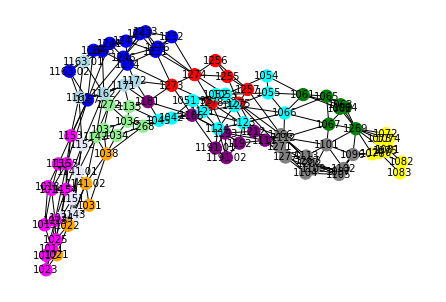

In [7]:
k = 12
test = mod_max_weighted(stl,k)
nx.write_gexf(test, "Graphs\Communities.gexf")
colors = [test.nodes[node]['cluster'] for node in test.nodes()]
color_dict = {0:'lightgreen', 1:'lightblue', 2:'lavender', 3:'orange', 4:'red', 5:'purple', 6:'yellow', 7:'green', 8:'blue', 9:'magenta', 10:'cyan', 11:'gray'}
new_colors = [color_dict[key] for key in colors]
#print(new_colors)
nx.draw(test, with_labels=True, node_size=150, node_color=new_colors, font_size=10)
plt.show()

## Getting centroid of each community and outputting as a new plan 
(output: point shapefile with all centroids containing a color attribute and a point shapefile comtaining the geomatric mean of each community, a new plan)
install geopandas and fiona to run.

In [10]:
import geopandas as gpd
from shapely.geometry import Point, LineString
from matplotlib.colors import ListedColormap
from shapely.geometry import MultiPoint

#grab output graph info 
# centroids_shp = r"data\Centroids.shp"
graph = nx.read_gexf("capstone.gexf")
colors = [graph.nodes[node]['cluster'] for node in test.nodes()]
labels = [graph.nodes[node]['label'] for node in test.nodes()]
gdf = gpd.GeoDataFrame(graph.nodes(data=True), columns=['geometry', 'attributes'])
# Add colors and labels to the GeoDataFrame
gdf['color'] = colors
gdf['NAME'] = labels

centroids_shp = r"data\Centroids.shp"
#centroids_shp = r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\Centroids.shp"
CentroidsInfo = gpd.read_file(centroids_shp)
# Add color information to centroids GeoDataFrame
centroids_gdf = gdf.merge(CentroidsInfo, on='NAME')
centroids_gdf = gpd.GeoDataFrame(centroids_gdf.rename(columns={'geometry_y': 'geometry'}))
centroids_gdf = centroids_gdf.drop(columns=['geometry_x','attributes'])
centroids_gdf = centroids_gdf.to_crs('EPSG:4326') 
#centroids_gdf['centroid'] = centroids_gdf.groupby('color')['geometry'].transform(lambda x: MultiPoint(x).centroid)


def calculate_centroid(group):
    print(MultiPoint(group.geometry.values).centroid)
    return MultiPoint(group.geometry.values).centroid

cent = centroids_gdf.groupby('color').apply(calculate_centroid)
newPlan = gpd.GeoDataFrame(geometry = cent)
#newPlan['color'] = range(len(newPlan))

centroids_gdf['geometry'] = centroids_gdf['geometry'].apply(lambda x: Point(x))
new_centroids_gdf = gpd.GeoDataFrame(centroids_gdf, geometry='geometry', crs='EPSG:4326')

# Save to file
newPlan.to_file(r"data\newPlanClust.shp", crs="EPSG:4326")
#.to_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\newPlanClust.shp",crs="EPSG:4326")
centroids_gdf.to_file(r"data\centroidsColoredByCommunity.shp",crs="EPSG:4326")
#centroids_gdf.to_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\centroidsColoredByCommunity.shp",crs="EPSG:4326")



display(newPlan)

POINT (-90.25441111916778 38.60465515908728)
POINT (-90.28960677224143 38.60996501880351)
POINT (-90.27608195200624 38.58688570159957)
POINT (-90.30240325312752 38.58483610111618)
POINT (-90.2083719729195 38.629041353728894)
POINT (-90.24517976339467 38.639232262107676)
POINT (-90.26658267064282 38.67507248923384)
POINT (-90.24036008920223 38.70582369107773)
POINT (-90.22678292400172 38.598359394114496)
POINT (-90.26226722008094 38.564548115588394)
POINT (-90.28001168863473 38.649649078764604)
POINT (-90.21965240200981 38.66316339908188)


,geometry
color,
0,POINT (-90.25441 38.60466)
1,POINT (-90.28961 38.60997)
2,POINT (-90.27608 38.58689)
3,POINT (-90.30240 38.58484)
4,POINT (-90.20837 38.62904)
5,POINT (-90.24518 38.63923)
6,POINT (-90.26658 38.67507)
7,POINT (-90.24036 38.70582)
8,POINT (-90.22678 38.59836)


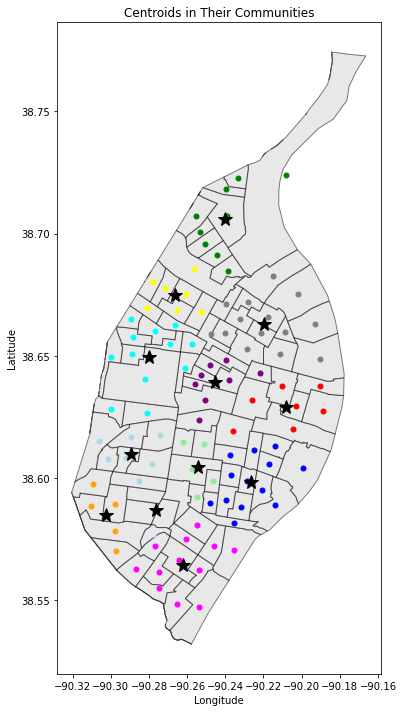

In [14]:
# Read the tracts shapefile
tracts = gpd.read_file(r"data\census tracts\CensusTractsStl.shp")
#tracts = gpd.read_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\census tracts\CensusTractsStl.shp")

# Plotting the graph and tracts polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Plot tracts polygons
tracts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

coloredCentroids = gpd.read_file(r"data\centroidsColoredByCommunity.shp")
#coloredCentroids = gpd.read_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\centroidsColoredByCommunity.shp")
color_dict = {0:'lightgreen', 1:'lightblue', 2:'lavender', 3:'orange', 4:'red', 5:'purple', 6:'yellow', 7:'green', 8:'blue', 9:'magenta', 10:'cyan', 11:'gray'}
cmap = ListedColormap([color_dict[i] for i in range(len(color_dict))])

coloredCentroids.head()


#uncomment this if you want prettier colors but uglier code
# Plot centroids from centroidsColoredByCommunity.shp with colormap
for _, row in coloredCentroids.iterrows():
    centroid = row['geometry'].centroid  # Get centroid of the polygon
    color = color_dict[row['color']]
    ax.plot(centroid.x, centroid.y, marker='o', color=color, markersize=5)  # Use colormap for centroids

#uncomment this if you want uglier colors but sinmpler code 
#coloredCentroids.plot(ax=ax, column='color', cmap=cmap, legend=True) 

# Plot centroids of polygons from newPlanClust.shp
newPlan = gpd.read_file(r"data\newPlanClust.shp")
#newPlan = gpd.read_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\newPlanClust.shp")
for _, row in newPlan.iterrows():
    centroid = row['geometry'].centroid  # Get centroid of the polygon
    ax.plot(centroid.x, centroid.y, marker='*', color='black', markersize=15)

ax.set_title('Centroids in Their Communities')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()